# Vanilla Autoencoder

This is a work-in-progress tutorial on how to create a simple autoencoder for separating signal from background.

### Imports

In [1]:
from IPython.display import Image, SVG
%matplotlib inline

import time
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

import keras
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LeakyReLU, Conv2D, UpSampling2D, Flatten, Reshape, Lambda
from keras import regularizers
from keras.constraints import UnitNorm, MaxNorm

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

Using TensorFlow backend.


***
## HYPERPARAMETERS & OPTIONS

In [2]:
### DATA SELECTION ###
bkg_filename = "../background_Full_Test3.txt"
sig_filename = "../signal_Full_Test3.txt"
drop_PHI_columns = False
f_b = 0.5
scaler = Normalizer()

### OPTIONS ###
savePlots = True
plotsLocation = "./"

### AUTOENCODER ###
encoding_dim = 5
deepArchitecture = True
leak=0.5
epochs= 200

***
### Load the data files

We have simulated signal and background events with two jets, each jet being caracterized by $(p_x, p_y, p_z, E, M)$ In adition to this we have the invariant mass of the two jets $M_{1 2}$ and two topological parameters: $C$ - *centricity* and $S$ - *sfericity*.

The files are loaded into dataframes using pandas.

In [3]:
bkg_all = pd.read_csv(bkg_filename, delimiter=' ', index_col=False)
sig_all = pd.read_csv(sig_filename, delimiter=' ', index_col=False)
coordinates_transformed = False

***
### Coordinate transformation 
The coordinates of the data are transformed to a more useful coordinate system $(p_x, p_y, p_z, E) \rightarrow (p_t, \eta, \phi, E)$ using the following formulas:

> $p_t = \sqrt{p_x^2 + p_y^2}$ <br> $\eta = - \ln{( \tan{\dfrac{\theta}{2})}}$ , where $\theta = atan2 (p_t, p_z)$ <br> $\phi = atan2(p_y, p_x)$

The transformation function changes the dataframe, so runing it more than once will generate errors. The check on the variable *coordinates_transformed* has the role of preventing consecutive executions of the function.

In [4]:
def coordinate_change (df):
    pt1 = np.sqrt(df['px1']**2 + df['py1']**2)
    theta1 = np.arctan2(pt1,df['pz1'])
    eta1 = -1 * np.log(np.tan(theta1/2))
    phi1 = np.arctan2(df['py1'],df['px1'])
    pt2 = np.sqrt(df['px2']**2 + df['py2']**2)
    theta2 = np.arctan2(pt2,df['pz2'])
    eta2 = -1 * np.log(np.tan(theta2/2))
    phi2 = np.arctan2(df['py2'],df['px2'])
    df['px1'] = pt1
    df['py1'] = eta1
    df['pz1'] = phi1
    df['px2'] = pt2
    df['py2'] = eta2
    df['pz2'] = phi2
    df.rename(columns={'px1':'$p_{t1}$', 'py1':'$\eta_{1}$', 'pz1':'$\phi_{1}$', 'px2':'$p_{t2}$',
                       'py2':'$\eta_{2}$', 'pz2':'$\phi_{2}$', 'E1':'$E_1$', 'E2':'$E_2$', 'M1':'$M_1$',
                       'M2':'$M_2$', 'M12':'$M_{1 2}$'}, inplace=True)
    
if coordinates_transformed == False:
    coordinate_change(sig_all)
    coordinate_change(bkg_all)
    coordinates_transformed = True


***
### Data selection

Select the data that is of interest, in our case it could be everything.
**Optional:** We can drop the $\phi$ columns for both the signal and background, since their distribution is flat

The selected thata is shuflled before using it.

Now we choose the training data and the test data in the following way:

###### Training data
We take a fraction $f_b$ of available backgroud data used and use it for training purposes. In our example $f_b = 50 \%$.
 
###### Test data
The rest of the background data alaong with an equal amount of signal events will be used as our test data.
 

In [5]:
if drop_PHI_columns:
    sig_sel = sig_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
    bkg_sel = bkg_all.drop(columns = ['$\phi_{1}$', '$\phi_{2}$'])
else:
    sig_sel = sig_all
    bkg_sel = bkg_all
    
data_header = list(sig_sel)

sig_shuffled = shuffle(sig_sel)
bkg_shuffled = shuffle(bkg_sel)

n_bkg = len(bkg_sel.iloc[:,:0])
n_sig = len(sig_sel.iloc[:,:0])
n_train = int(f_b * n_bkg)
n_test_sig = int((1-f_b)*n_bkg) 
n_test = n_bkg - n_train + n_test_sig
f_s = n_test_sig/n_sig

print ("Number of BACKGROUND events:", n_bkg)
print ("{0}% = {1}".format(f_b*100, n_train), "used for TRAINING")
print ("{0}% = {1}".format((1-f_b)*100, n_bkg-n_train), "used for TESTING")
print ("Number of SIGNAL events:", n_sig)
print ("%.2f%% = %d" % (f_s*100, n_test_sig), "used for TESTING")
print ("\n")
print ("TRAINING sample size:", n_train)
print ("TESTING sample size:", n_test)

sample_train = bkg_sel[:n_train]
sample_test = pd.concat([bkg_sel.iloc[n_train:], sig_sel.iloc[:n_test_sig]])
sample_test = sample_test.reset_index(drop=True)

input_dim = sample_train.shape[1]

Number of BACKGROUND events: 54194
50.0% = 27097 used for TRAINING
50.0% = 27097 used for TESTING
Number of SIGNAL events: 52766
51.35% = 27097 used for TESTING


TRAINING sample size: 27097
TESTING sample size: 54194


***
### Vizualitation of the selected data

Distributions of the data for the TRAINING and TESTING samples


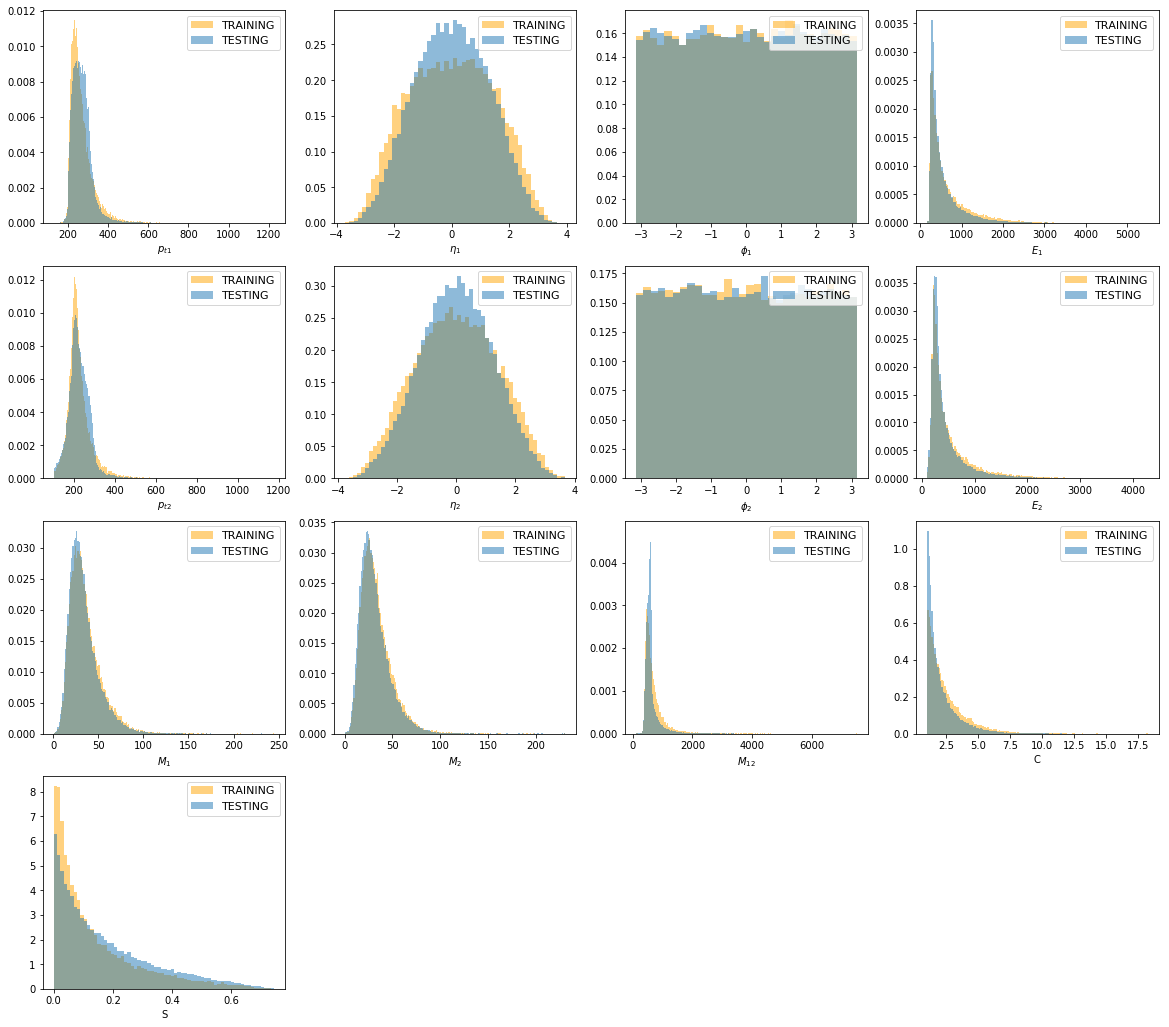

In [6]:
print("Distributions of the data for the TRAINING and TESTING samples")
plt.figure(figsize=(20, 18))
for i in range(sample_test.shape[1]):
    plt.subplot(4, 4, i+1)
    n, bins, patches = plt.hist(sample_train.iloc[:,i], bins='auto', color = 'orange', alpha=0.5, label='TRAINING', density=True)
    plt.hist(sample_test.iloc[:,i], bins, alpha=0.5, label='TESTING', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best', prop={'size': 11})
    
if savePlots:
    plt.savefig(plotsLocation + 'selected_data.png')

***
### Data rescaling and partitioning

In order to ensure that variations of each feature contributes to the variation of calculated distances with the same amount, we need to normalize. This can be accomplished using rescalers which may be:
-  **MinMax Scaler:**
The value of every feature is mapped to the interval $[0;1]$ with:

> $\mathrm{x^{'}} = \dfrac{\mathrm{x}-x_{min}}{x_{max}-x_{min}}$

-  **Standard Scaler:**
Standardize by removing the mean and scaling to unit variance 

> $\mathrm{z} = \dfrac{\mathrm{x} - u}{s}$, where:
<br> 
 $u$ is the mean of the sample or $0$, if `with_mean` = False 
<br> $s$ is the standard deviation or $1$ if `with_std` = False

-  **Normalizer:**
Normalize samples individually to unit norm

The function `scaler.fit_transform()` rescales the data according to the selected scaler, the parameters used for rescaling are saved and will be used for future calls of `scaler.transform()`.

Data is then partitioned 80% for training and 20% for validation

In [7]:
sample_train = scaler.fit_transform(sample_train)
sample_test = scaler.transform(sample_test)

print('Training sample size: ',sample_train.shape)
print('Testing sample size: ',sample_test.shape)

sample_train_input, sample_train_valid = train_test_split(sample_train,test_size=0.2,random_state=13) 

Training sample size:  (27097, 13)
Testing sample size:  (54194, 13)


***
### Autoencoder setup

In [8]:
hidden_activation = 'linear'
encoder_activation = 'tanh'
decoder_activation = 'tanh'
#constraint = UnitNorm(axis=0)
#constraint = MaxNorm(max_value=3, axis=0)
constraint = None

if not(deepArchitecture):
    autoencoder = Sequential()
    autoencoder.add(
        Dense(encoding_dim, input_shape=(input_dim,), activation='linear', activity_regularizer=regularizers.l1(1e-5))
    )
    autoencoder.add(
        Dense(input_dim, activation='tanh')
    )
    
else:
    # Encoder Layers
    encoder_in = Input(shape=(input_dim,))
    encoder_1 = Dense(20, activation=hidden_activation, kernel_constraint=constraint)(encoder_in)
    activate_e1 = LeakyReLU(alpha=leak)(encoder_1)
    encoder_2 = Dense(17, activation=hidden_activation, kernel_constraint=constraint)(activate_e1)
    activate_e2 = LeakyReLU(alpha=leak)(encoder_2)
    encoder_3 = Dense(14, activation=hidden_activation, kernel_constraint=constraint)(activate_e2)
    activate_e3 = LeakyReLU(alpha=leak)(encoder_3)
    encoder_4 = Dense(12, activation=hidden_activation, kernel_constraint=constraint)(activate_e3)
    activate_e4 = LeakyReLU(alpha=leak)(encoder_4)
    encoder_5 = Dense(10, activation=hidden_activation, kernel_constraint=constraint)(activate_e4)
    activate_e5 = LeakyReLU(alpha=leak)(encoder_5)
    encoder_6 = Dense(7, activation=hidden_activation, kernel_constraint=constraint)(activate_e5)
    activate_e6 = LeakyReLU(alpha=leak)(encoder_6)
    encoder_out = Dense(encoding_dim, activation=encoder_activation, kernel_constraint=constraint)(activate_e6)

    # Decoder Layers
    decoder_1 = Dense(7, activation=hidden_activation, kernel_constraint=constraint)(encoder_out)
    activate_d1 = LeakyReLU(alpha=leak)(decoder_1)
    decoder_2 = Dense(10, activation=hidden_activation, kernel_constraint=constraint)(activate_d1)
    activate_d2 = LeakyReLU(alpha=leak)(decoder_2)
    decoder_3 = Dense(12, activation=hidden_activation, kernel_constraint=constraint)(activate_d2)
    activate_d3 = LeakyReLU(alpha=leak)(decoder_3)
    decoder_4 = Dense(14, activation=hidden_activation, kernel_constraint=constraint)(activate_d3)
    activate_d4 = LeakyReLU(alpha=leak)(decoder_4)
    decoder_5 = Dense(17, activation=hidden_activation, kernel_constraint=constraint)(activate_d4)
    activate_d5 = LeakyReLU(alpha=leak)(decoder_5)
    decoder_6 = Dense(20, activation=hidden_activation, kernel_constraint=constraint)(activate_d5)
    activate_d6 = LeakyReLU(alpha=leak)(decoder_6)
    decoder_out = Dense(input_dim, activation=decoder_activation, kernel_constraint=constraint)(activate_d6)
  
    autoencoder = Model(encoder_in, decoder_out)
    encoder = Model(encoder_in, decoder_out)
    
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                280       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 17)                357       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 17)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                252       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14)                0         
__________

***
### Training

In [9]:
# Recording loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory()

start = time.time()
with tf.device('/GPU:0'):
    autoencoder_train = autoencoder.fit(sample_train_input, sample_train_input,
                epochs=epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(sample_train_valid, sample_train_valid),
                callbacks=[history])
end = time.time()
train_time = (end-start)


Train on 21677 samples, validate on 5420 samples
Epoch 1/200
21677/21677 [==============================] - 1s 47us/step - loss: 0.0246 - val_loss: 0.0090
Epoch 2/200
21677/21677 [==============================] - 0s 19us/step - loss: 0.0084 - val_loss: 0.0059
Epoch 3/200
21677/21677 [==============================] - 1s 27us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 4/200
21677/21677 [==============================] - 1s 25us/step - loss: 0.0014 - val_loss: 6.8701e-04
Epoch 5/200
21677/21677 [==============================] - 0s 18us/step - loss: 6.3289e-04 - val_loss: 5.8008e-04
Epoch 6/200
21677/21677 [==============================] - 1s 29us/step - loss: 5.5854e-04 - val_loss: 5.2457e-04
Epoch 7/200
21677/21677 [==============================] - 0s 20us/step - loss: 4.9952e-04 - val_loss: 4.6302e-04
Epoch 8/200
21677/21677 [==============================] - 1s 24us/step - loss: 4.1984e-04 - val_loss: 3.5472e-04
Epoch 9/200
21677/21677 [==============================] - 1s 27us/

21677/21677 [==============================] - 1s 28us/step - loss: 5.5579e-05 - val_loss: 5.3825e-05
Epoch 73/200
21677/21677 [==============================] - 1s 35us/step - loss: 5.1795e-05 - val_loss: 5.0135e-05
Epoch 74/200
21677/21677 [==============================] - 1s 38us/step - loss: 5.0583e-05 - val_loss: 5.7467e-05
Epoch 75/200
21677/21677 [==============================] - 1s 33us/step - loss: 4.9492e-05 - val_loss: 5.5231e-05
Epoch 76/200
21677/21677 [==============================] - 1s 24us/step - loss: 4.9585e-05 - val_loss: 4.7290e-05
Epoch 77/200
21677/21677 [==============================] - 1s 29us/step - loss: 4.7885e-05 - val_loss: 4.4194e-05
Epoch 78/200
21677/21677 [==============================] - 1s 26us/step - loss: 4.7055e-05 - val_loss: 5.0442e-05
Epoch 79/200
21677/21677 [==============================] - 0s 22us/step - loss: 4.6516e-05 - val_loss: 4.2151e-05
Epoch 80/200
21677/21677 [==============================] - 0s 20us/step - loss: 4.5300e-05 -

Epoch 143/200
21677/21677 [==============================] - 0s 20us/step - loss: 4.1255e-05 - val_loss: 3.7856e-05
Epoch 144/200
21677/21677 [==============================] - 1s 27us/step - loss: 4.0986e-05 - val_loss: 3.9019e-05
Epoch 145/200
21677/21677 [==============================] - 1s 28us/step - loss: 4.0097e-05 - val_loss: 4.0386e-05
Epoch 146/200
21677/21677 [==============================] - 1s 32us/step - loss: 4.0479e-05 - val_loss: 4.2128e-05
Epoch 147/200
21677/21677 [==============================] - 1s 35us/step - loss: 4.0106e-05 - val_loss: 3.8156e-05
Epoch 148/200
21677/21677 [==============================] - 0s 20us/step - loss: 4.1641e-05 - val_loss: 3.7281e-05
Epoch 149/200
21677/21677 [==============================] - 1s 31us/step - loss: 3.9677e-05 - val_loss: 3.9028e-05
Epoch 150/200
21677/21677 [==============================] - 1s 32us/step - loss: 4.0408e-05 - val_loss: 3.7817e-05
Epoch 151/200
21677/21677 [==============================] - 1s 29us/ste

***
### Loss & Validation

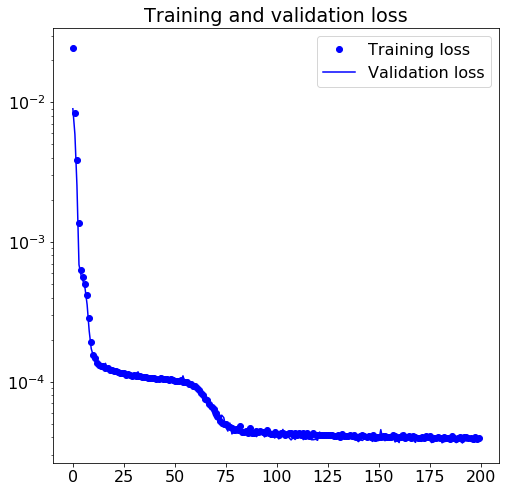

In [10]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
nepochs = range(epochs)
lossFig = plt.figure(figsize=(8,8))
plt.rcParams.update({'font.size': 16})
plt.plot(nepochs, loss, 'bo', label='Training loss')
plt.plot(nepochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.yscale('log')
plt.legend()
plt.show()

***
### Figure of merit

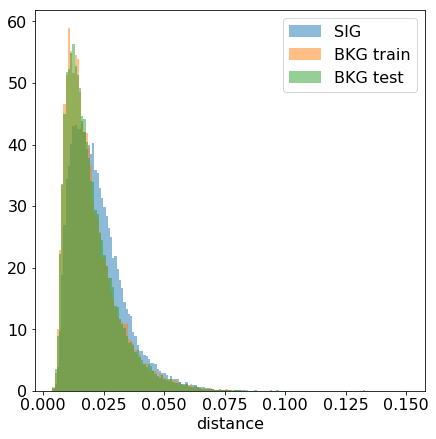

In [13]:
decoded_imgs = autoencoder.predict(sample_test)
decoded_imgs_train = autoencoder.predict(sample_train)

# Calculate L2 norm of train and test samples
# norm = |x_in - x_out|^2

norm_bkg_test=[]
for i in range(sample_test.shape[0]//2):
    norm_bkg_test += [norm(sample_test[i,:]-decoded_imgs[i,:])]
    
norm_sig=[]
for i in range(sample_test.shape[0]//2, sample_test.shape[0]):
    norm_sig += [norm(sample_test[i,:]-decoded_imgs[i,:])]

norm_bkg_train=[]
for i in range(sample_train.shape[0]):
    norm_bkg_train += [norm(sample_train[i,:]-decoded_imgs_train[i,:])]

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(norm_sig, bins='auto', alpha=0.5, label='SIG', density=True)
plt.hist(norm_bkg_train, bins, alpha=0.5, label='BKG train', density=True)
plt.hist(norm_bkg_test, bins, alpha=0.5, label='BKG test', density=True)
plt.xlabel('distance')
plt.legend(loc='upper right')

if savePlots:
    plt.savefig(plotsLocation + "distances.png")

***
### ROC curve

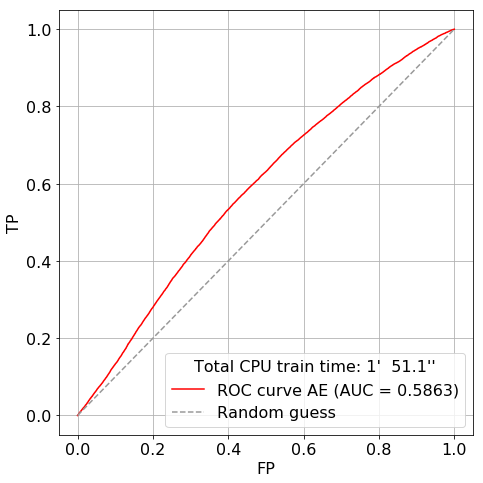

In [14]:
target = np.concatenate((np.zeros(sample_train.shape[0] + sample_test.shape[0]//2),np.ones(n_train)))
scores = np.concatenate((norm_bkg_train,norm_bkg_test, norm_sig))  

train_min = int(train_time) // 60
train_sec = train_time - 60 * train_min
time_stamp = "Total CPU train time: %d'  %.1f''" % (train_min, train_sec)

plt.figure(figsize=(7, 7))
                   
fp, vp, thresholds = roc_curve(target,scores)
roc_auc = auc(fp, vp)

plt.plot(fp,vp,color='red',label='ROC curve %s (AUC = %0.4f)'%('AE',roc_auc))
plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1], linestyle='--',color=(0.6, 0.6, 0.6), label='Random guess')
plt.grid()
plt.legend(loc="best", title =time_stamp)
plt.tight_layout()

if savePlots:
    plt.savefig(plotsLocation + "ROC.png")

***
### Encoding Variables Distribution

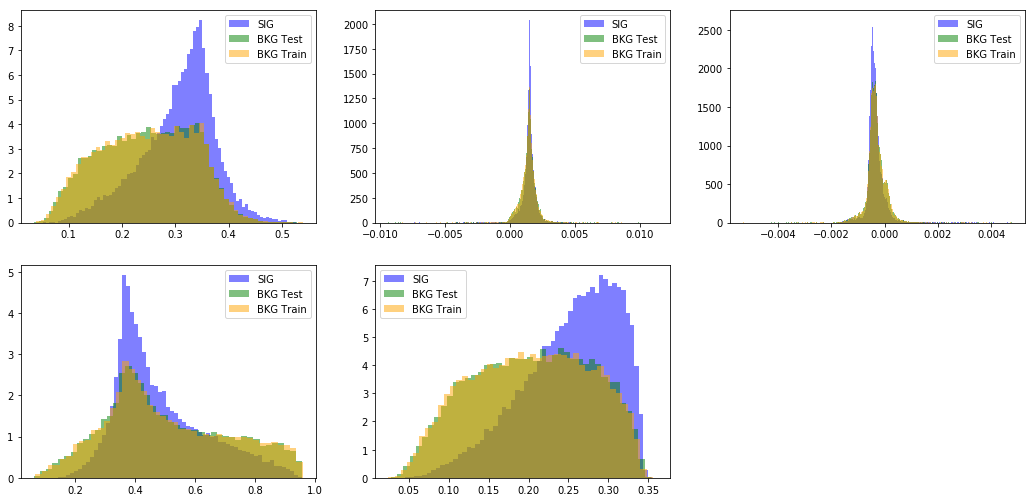

In [20]:
encoded_train = encoder.predict(sample_train)
encoded_bkg = encoder.predict(sample_test[:sample_train.shape[0],])
encoded_sig = encoder.predict(sample_test[sample_train.shape[0]:sample_test.shape[0],])

plt.rcParams.update({'font.size': 10})

encFig = plt.figure(figsize=(18, 18))
for i in range(encoding_dim):
    plt.subplot(4, 3, i+1)
    n, bins, patches=plt.hist(encoded_sig[:,i], bins='auto', alpha=0.5, label='SIG', color='blue', density=True)
    n, bins, patches=plt.hist(encoded_bkg[:,i], bins='auto', alpha=0.5, label='BKG Test', color='green',  density=True)
    n, bins, patches=plt.hist(encoded_train[:,i], bins='auto', alpha=0.5, label='BKG Train', color='orange', density=True)
    plt.legend(loc='best')
plt.show()
#encFig.savefig(plotsLocation + "Encoding.png")

### Visualizations

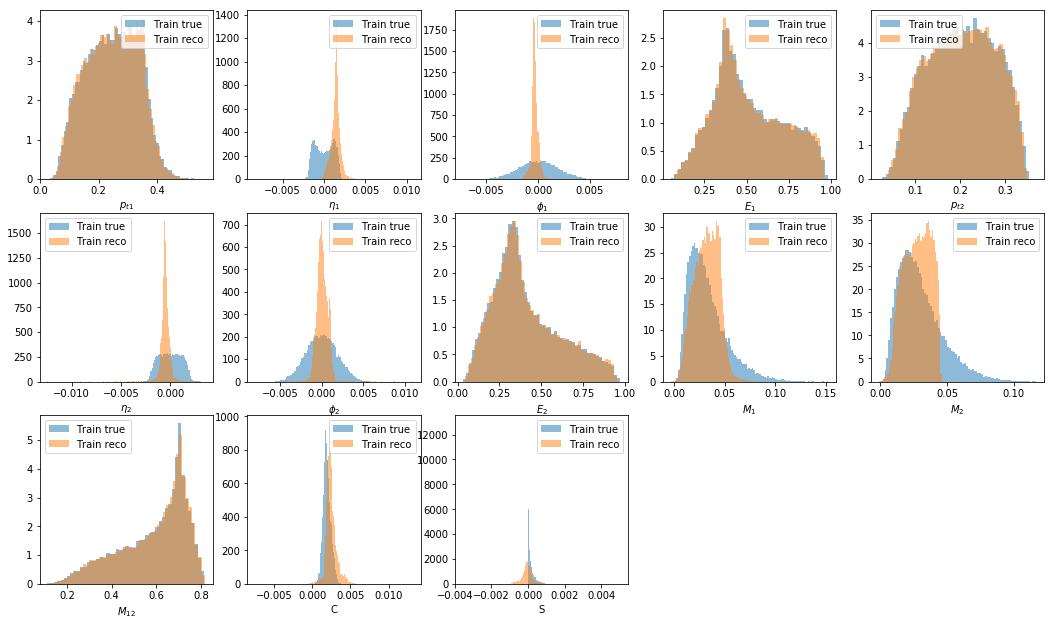

In [18]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.hist(sample_train[:,i], bins='auto', alpha=0.5, label='Train true', density=True)
    plt.hist(decoded_imgs_train[:,i], bins='auto', alpha=0.5, label='Train reco', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')
#plt.savefig(plotsLocation + "Reco.png")

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[:sample_test.shape[0]//2,i], bins='auto', alpha=0.5, label='Test bkg true', density=True)
    n, bins, patches = plt.hist(decoded_imgs[:sample_test.shape[0]//2,i], bins, alpha=0.5, label='Test bkg reco', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')
    

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(sample_train.shape[1]):
    plt.subplot(5, 5, i+1)
    n, bins, patches = plt.hist(sample_test[sample_test.shape[0]//2:sample_test.shape[0],i], bins='auto', alpha=0.5, label='Test sig true', density=True)
    n, bins, patches = plt.hist(decoded_imgs[sample_test.shape[0]//2:sample_test.shape[0],i], bins, alpha=0.5, label='Test sig reco', density=True)
    plt.xlabel(data_header[i])
    plt.legend(loc='best')